### Usage
This notebook shows how we measured the robustness of the network using two different strategies for node removal, random and based on centrality measures.

#### Importing libraries

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random 
import heapq
import seaborn as sns
from tqdm import tqdm

from centrality import *

#### Loading the graph from csv file

In [4]:
def build_graph():
    df = pd.read_csv('top_1000_by_liquidity.csv')
    edges = pd.DataFrame(
    {
        "source": df["token0.symbol"],
        "target": df["token1.symbol"],
        "weight": df["reserveUSD"],
    }
    )
    G = nx.from_pandas_edgelist(edges, edge_attr=True, create_using=nx.Graph().to_undirected())
    return G

#### Functions to remove nodes

#### 1) Randomly

In [5]:
def remove_node_randomly(G, num):
    """ Remove Node Randomly

    This function removes nodes randomly from the full graph and returns the remaining graph

    :param G: the input graph
    :param num: number of nodes to remove at random
    :return g_rem: the remaining graph with nodes randomly removed
    """
    g_rem = G.copy()
    nodes_g = list(g_rem.nodes)
    ran_sample = random.sample(nodes_g, num)
    g_rem.remove_nodes_from(ran_sample)
    
    return g_rem


#### 2) Based on a given centrality measure

In [6]:
def remove_most_important_nodes(G, num, centrality_measure):
    """ Remove Most Important Nodes

    This function removes the most important node from the input graph, with the importance of the node being determined by the centrality measure

    :param num: the number of most important nodes to remove
    :param G: the input graph
    :param centrality_measure: the centrality measure used  #todo: verify this with Kartikey
    :return g_rem: the remaining graph with the most important node removed
    """
    g_rem = G.copy()
    rem_sample = heapq.nlargest(num, centrality_measure, key=centrality_measure.get)
    g_rem.remove_nodes_from(rem_sample)

    return g_rem


#### Function to check robustness - based on Diameter of the Graph

In [7]:
def robustness():
    """ Robustness

    This function calculates the min, max and avg. diameter across all the subgraphs in the network by iteratively removing one node randomly from the input graph

    :return: list of all the min, max, and avg. diameter values
    """
    G = build_graph()
    num_nodes = len(list(G.nodes()))

    diameter_list_min = []
    diameter_list_max = []
    diameter_list_average = []
    num_of_sugraphs_list = []

    removed_nodes = [0]
    nodes_to_be_deleted = 1
    rem_counter  = 0 

    for x in tqdm(range(int(num_nodes/nodes_to_be_deleted))):

        if x == 0:
            list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

            num_of_sugraphs_list.append(len(list_sub_graphs))
            diameters = [nx.diameter(subgraph) for subgraph in list_sub_graphs]
            diameter_list_min.append(min(diameters))
            diameter_list_max.append(max(diameters))
            diameter_list_average.append(sum(diameters)/len(diameters))

        G_new = remove_node_randomly(G, nodes_to_be_deleted)
        rem_counter = rem_counter + nodes_to_be_deleted
        
        list_sub_graphs = list(G_new.subgraph(c) for c in nx.connected_components(G_new))

        num_of_sugraphs_list.append(len(list_sub_graphs))
        diameters = [nx.diameter(subgraph) for subgraph in list_sub_graphs]
        diameter_list_min.append(min(diameters))
        diameter_list_max.append(max(diameters))
        diameter_list_average.append(sum(diameters)/len(diameters))
        removed_nodes.append(rem_counter)

    plt.figure(figsize=(12,8))
    plt.title("Variation of the diameter values across all subgraphs of the network")
    plt.xlabel("Number of nodes removed")
    plt.ylabel("diameter values across all subgraphs")
    plt.plot(removed_nodes, diameter_list_min, linestyle="-", marker="o", label="min diameter across all subgraphs", color="blue", alpha=0.2)
    plt.plot(removed_nodes, diameter_list_max, linestyle="-", marker="o", label="max diameter across all subgraphs", color="blue", alpha=0.2)
    plt.plot(removed_nodes, diameter_list_average, linestyle="-", marker="o", label="average diameter across all subgraphs", color="red")
    plt.legend()
    plt.show()

    

In [8]:
robustness()

  0%|          | 4/934 [00:17<1:05:58,  4.26s/it]


KeyboardInterrupt: 

In [9]:
def robustness_random_failures():
    """Robustness Random Failures

    This function calculates the relative size of the giant component of the graph w.r.t fraction of nodes randomly removed

    :return nodes_giant_comp_list: list of number of nodes of giant component
    :return removed_nodes: list of nodes removed
    :return pf_div_p0: relative size of the giant component of the graph relative to the number of nodes
    """
    G = build_graph()

    num_nodes = len(list(G.nodes()))
    removed_nodes = [0]
    nodes_giant_comp_list = []
    pf_div_p0 = []

    nodes_to_be_deleted = 1

    rem_counter = 0

    for x in tqdm(range(int(num_nodes / nodes_to_be_deleted)-1)):

        if x == 0:
            list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

            giant_comp = max(list_sub_graphs, key=len)
            giant_comp_nodes = len(list(giant_comp.nodes()))
            nodes_giant_comp_list.append(giant_comp_nodes)
            pf_div_p0.append(giant_comp_nodes / num_nodes)
            G_new = G

        G_new = remove_node_randomly(G_new, nodes_to_be_deleted)

        rem_counter = rem_counter + nodes_to_be_deleted

        list_sub_graphs = list(
            G_new.subgraph(c) for c in nx.connected_components(G_new)
        )
        giant_comp = max(list_sub_graphs, key=len)
        giant_comp_nodes = len(list(giant_comp.nodes()))
        nodes_giant_comp_list.append(giant_comp_nodes)

        percent_nodes_removed = rem_counter / num_nodes
        removed_nodes.append(percent_nodes_removed)
        pf_div_p0.append(giant_comp_nodes / num_nodes)

    return nodes_giant_comp_list, removed_nodes, pf_div_p0

In [10]:
def robustness_targeted_attacks(centrality):

    """Robustness Targeted Attacks

    This function calculates the relative size of the giant component of the graph w.r.t fraction of most central nodes removed

    :param centrality: which centrality to take into account
    :type mat: numpy.int64

    0 -> degree centrality
    1 -> betweenness centrality
    2 -> closeness centrality
    3 -> eigenvector centrality

    :return nodes_giant_comp_list: list of number of nodes of giant component
    :return removed_nodes: list of nodes removed
    :return pf_div_p0: relative size of the giant component of the graph relative to the number of nodes
    """

    G = build_graph()
    (
        centrality_measures
    ) = compute_centrality(G)

    num_nodes = len(list(G.nodes()))
    removed_nodes = [0]
    nodes_giant_comp_list = []
    pf_div_p0 = []

    nodes_to_be_deleted = 1

    rem_counter = 0

    for x in tqdm(range(int(num_nodes / nodes_to_be_deleted)-1)):

        if x == 0:
            list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

            giant_comp = max(list_sub_graphs, key=len)
            giant_comp_nodes = len(list(giant_comp.nodes()))
            nodes_giant_comp_list.append(giant_comp_nodes)
            pf_div_p0.append(giant_comp_nodes / num_nodes)
            G_new = G

        
        G_new = remove_most_important_nodes(
            G_new, nodes_to_be_deleted + x, centrality_measures[centrality]
        )

        rem_counter = rem_counter + nodes_to_be_deleted

        list_sub_graphs = list(
            G_new.subgraph(c) for c in nx.connected_components(G_new)
        )
        giant_comp = max(list_sub_graphs, key=len)
        giant_comp_nodes = len(list(giant_comp.nodes()))
        nodes_giant_comp_list.append(giant_comp_nodes)

        percent_nodes_removed = rem_counter / num_nodes
        removed_nodes.append(percent_nodes_removed)
        pf_div_p0.append(giant_comp_nodes / num_nodes)

    return nodes_giant_comp_list, removed_nodes, pf_div_p0

    

### Node Removal Simulation

We first remove the nodes randomly and next based on the importance of the node based on the centrality measures.

#### 1) Random Removal

In [17]:
(
    nodes_giant_comp_list_RND,
    removed_nodes_RND,
    pf_div_p0_RND,
) = robustness_random_failures()

100%|██████████| 933/933 [00:03<00:00, 243.78it/s]


#### 2) Degree Centrality

In [12]:
(
    nodes_giant_comp_list_ATTACK_0,
    removed_nodes_ATTACK_0,
    pf_div_p0_ATTACK_0,
) = robustness_targeted_attacks(0)

100%|██████████| 933/933 [00:09<00:00, 101.75it/s]


#### 3) Betweenness Centrality

In [13]:
(
    nodes_giant_comp_list_ATTACK_1,
    removed_nodes_ATTACK_1,
    pf_div_p0_ATTACK_1,
) = robustness_targeted_attacks(1)

100%|██████████| 933/933 [00:08<00:00, 105.39it/s]


#### 4) Closeness Centrality

In [14]:
(
    nodes_giant_comp_list_ATTACK_2,
    removed_nodes_ATTACK_2,
    pf_div_p0_ATTACK_2,
) = robustness_targeted_attacks(2)

100%|██████████| 933/933 [00:08<00:00, 105.79it/s]


#### 5) Eigenvector Centrality

In [15]:
(
    nodes_giant_comp_list_ATTACK_3,
    removed_nodes_ATTACK_3,
    pf_div_p0_ATTACK_3,
) = robustness_targeted_attacks(3)

100%|██████████| 933/933 [00:09<00:00, 103.58it/s]


### Plot

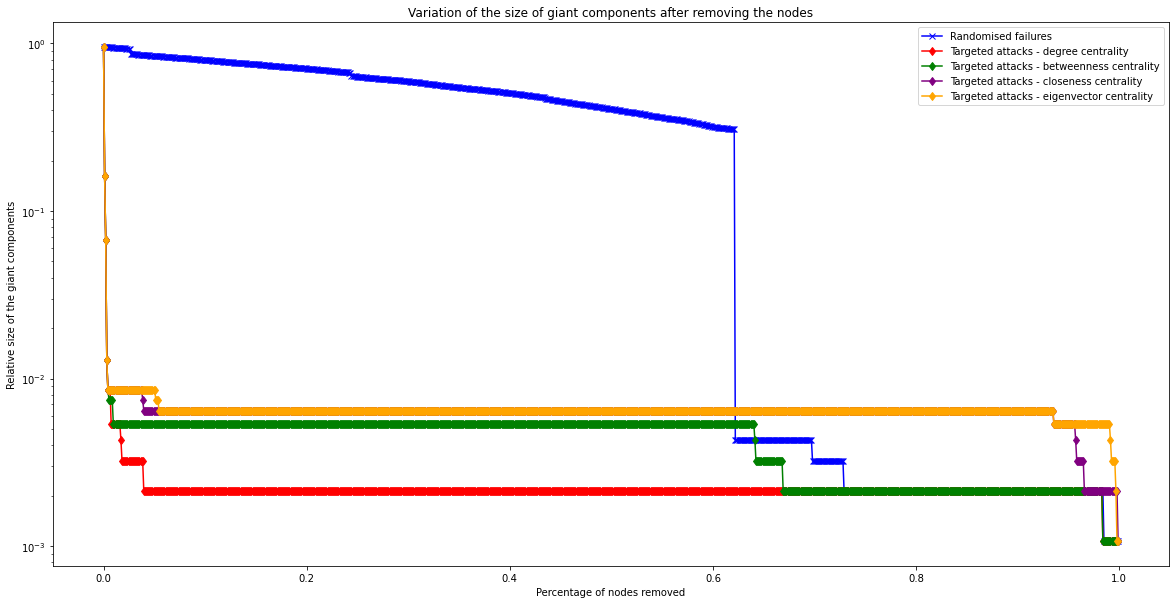

In [19]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.title("Variation of the size of giant components after removing the nodes")
plt.xlabel("Percentage of nodes removed")
plt.ylabel("Relative size of the giant components")
plt.yscale('log')

plt.plot(
    removed_nodes_RND,
    pf_div_p0_RND,
    linestyle="-",
    marker="x",
    label="Randomised failures",
    color="blue",
    alpha=1,
)
plt.plot(
    removed_nodes_ATTACK_0,
    pf_div_p0_ATTACK_0,
    linestyle="-",
    marker="d",
    label="Targeted attacks - degree centrality",
    color="red",
    alpha=1,
)

plt.plot(
    removed_nodes_ATTACK_1,
    pf_div_p0_ATTACK_1,
    linestyle="-",
    marker="d",
    label="Targeted attacks - betweenness centrality",
    color="green",
    alpha=1,
)

plt.plot(
    removed_nodes_ATTACK_2,
    pf_div_p0_ATTACK_2,
    linestyle="-",
    marker="d",
    label="Targeted attacks - closeness centrality",
    color="purple",
    alpha=1,
)

plt.plot(
    removed_nodes_ATTACK_3,
    pf_div_p0_ATTACK_3,
    linestyle="-",
    marker="d",
    label="Targeted attacks - eigenvector centrality",
    color="orange",
    alpha=1,
)

plt.legend()
plt.show()
fig.savefig("robustness_noderemoval.pdf", format="pdf")
